In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from tqdm import tqdm

In [44]:
class Particle:
    
    def __init__(self, r0, v0, a0, t, m=1, radius=2., Id=0):
        
        self.dt = t[1] - t[0]
        
        
        # Atributos instantaneos
        self.r = r0
        self.v = v0
        self.a = a0
        
        self.m = m
        self.radius = radius
        self.Id = Id
        
        
        self.p = self.m*self.v
        
        self.f = self.m*self.a
        
        # Historial
        
        self.R = np.zeros((len(t),len(r0)))
        self.V = np.zeros_like(self.R)
        self.A = np.zeros_like(self.R)
        
        self.F = np.zeros_like(self.R)
        
        self.P = np.zeros_like(self.R)
    
        # Fisica
        self.K = 20.
        
        self.VEk = np.zeros(len(t))
        self.PE = np.zeros_like(self.VEk)
        self.L = np.zeros_like(self.VEk)
        
    def Evolution(self,i):
        
        
        self.SetPosition(i)
        self.SetVelocity(i)
        
        
        self.a = self.f/self.m
        
        # Euler
        self.r += self.dt*self.v
        self.v += self.dt*self.a
        
        # Euler-Cromer
  #      self.v += self.dt*self.a
  #      self.r += self.dt*self.v
    
        if i>0:
            v1 = self.V[i-1]/(np.linalg.norm(self.V[i-1]))
            v2 = self.V[i]/(np.linalg.norm(self.V[i]))
            
            theta = np.arccos(np.clip(np.dot(v1, v2), -1.0, 1.0))
            
            omega = theta/self.dt
            I = (2/5) * self.m * self.radius**2
            
            self.L[i] = I*omega
            
            
        
        
    def CalculateForce(self,p, i):
        
        d = np.linalg.norm(self.r - p.r)
        
        compresion = self.radius + p.radius - d
        
        if compresion >= 0:
            
            Fn = self.K * compresion**3
            
            self.n = (self.r - p.r)/d     
            self.f = np.add(self.f,Fn*self.n)
            self.PE[i] = 0.25 * self.K * compresion**4
            
     
    def SetPotential(self, i):

        d = np.linalg.norm(self.r - p.r)
        compresion = self.radius + p.radius - d

        if compresion >= 0:
            self.PE[i] = 0.25 * self.K * compresion**4


    def ResetForce(self):
        self.f[:] = 0.
        self.a[:] = 0.
    
    # Setter
    def SetPosition(self,i):
        self.R[i] = self.r
    
    def SetVelocity(self,i):
        self.V[i] = self.v
        self.P[i] = self.m*self.v
        self.VEk[i] = 0.5*self.m*np.dot(self.v,self.v)
    
    # Getter
    def GetPosition(self,scale=1):
        return self.R[::scale]
    
    def GetVelocity(self,scale=1):
        return self.V[::scale]
 
    def GetMomentum(self,scale=1):
        return self.P[::scale]
    
    def GetKineticEnergy(self,scale=1):
        return self.VEk[::scale] 
    
    def GetPotential(self,scale=1):
        return self.PE[::scale]
    
    def Rebote(self, i):

        pared = 20

        vinv = np.array([1, -1])
        hinv = np.array([-1, 1])
        inv = np.array([hinv, vinv])
        
        pos1 = self.R[i] + np.full(len(self.R[i]), self.radius)
        pos2 = self.R[i] - np.full(len(self.R[i]), self.radius)
  
        if np.any(pos1 >= pared) or np.any(pos2 <= -pared):
            for k in range(len(pos1)):
                if pos1[k] >= pared or pos2[k] <= -pared:
                    self.v = self.v * inv[k]
                    pos1 = self.r + np.full(len(self.r), self.radius)
                    pos2 = self.r - np.full(len(self.r), self.radius)
                    while np.any(pos1 >= pared) or np.any(pos2 <= -pared):
                        self.r += self.v * self.dt
                        pos1 = self.r + np.full(len(self.r), self.radius)
                        pos2 = self.r - np.full(len(self.r), self.radius)

In [45]:
def GetParticles(N,t):
    
    part = np.linspace(0, N-1, N)
    Particles = []
    
    for i in part:
        r0 = np.random.uniform(low=-18.5, high=18.5, size=2)
        v0 = np.random.uniform(low=-5, high=5, size=2)
        a0 = np.zeros(2)
        p0 = Particle(r0, v0, a0, t, m=1, radius=2, Id=i)
        Particles.append(p0)
    
    return Particles

In [46]:
dt = 0.001
tmax = 10
t = np.arange(0,tmax,dt)
Particles = GetParticles(10,t)

In [47]:
def RunSimulation(t,Particles):
    
    for it in tqdm(range(len(t)), desc='Running simulation', unit=' Steps' ):
        
        for i in range(len(Particles)):
            for j in range(len(Particles)):
                if i!=j:
                    Particles[i].CalculateForce(Particles[j], it)
        
        for i in range(len(Particles)):
            Particles[i].Evolution(it)
            Particles[i].ResetForce()
            #Particles[i].Rebote(it)
            
            
    return Particles

In [48]:
Particles = RunSimulation(t,Particles)

Running simulation: 100%|███████████████████████████████████████████████████| 10000/10000 [00:13<00:00, 752.84 Steps/s]


In [49]:
# Bajamos dimensión de la simulacion
scale = 200
t1 = t[::scale]

<IPython.core.display.Javascript object>


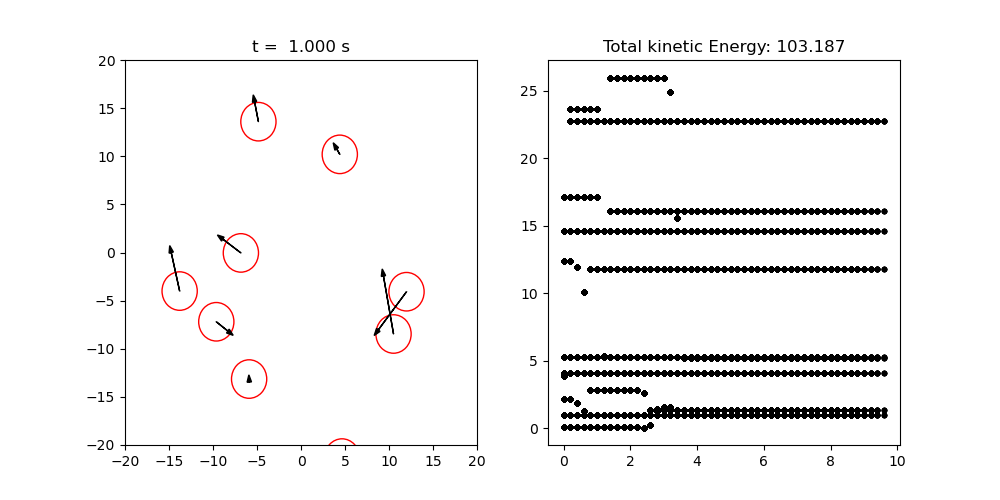

In [50]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

def init():
    
    ax.clear()
    ax.set_xlim(-20,20)
    ax.set_ylim(-20,20)
    
def Update(i):
    
    init()
    ax.set_title(r't =  %.3f s' %(t1[i]))
    
    
    # Queremos calcular la energía total de cinética
    KE = 0. # Kinetic energy
    
    for p in Particles:
        
        x = p.GetPosition(scale)[i,0]
        y = p.GetPosition(scale)[i,1]
        
        vx = p.GetVelocity(scale)[i,0]
        vy = p.GetVelocity(scale)[i,1]
        
        circle = plt.Circle( (x,y), p.radius, color='r', fill=False )
        ax.add_patch(circle)
        
        ax.arrow(x,y,vx,vy,color='k',head_width=0.5,length_includes_head=True)
        
        KE += p.GetKineticEnergy(scale)[i]
        
        ax1.set_title(r'Total kinetic Energy: {:.3f}'.format(KE))
        ax1.scatter(t1[:i], p.GetKineticEnergy(scale)[:i],color='k',marker='.')
        
Animation = anim.FuncAnimation(fig,Update,frames=len(t1),init_func=init)



In [51]:
MomentumT = Particles[0].GetMomentum(scale)

In [52]:
for i in range(1,len(Particles)):
    MomentumT = np.add(MomentumT,Particles[i].GetMomentum(scale))

<IPython.core.display.Javascript object>


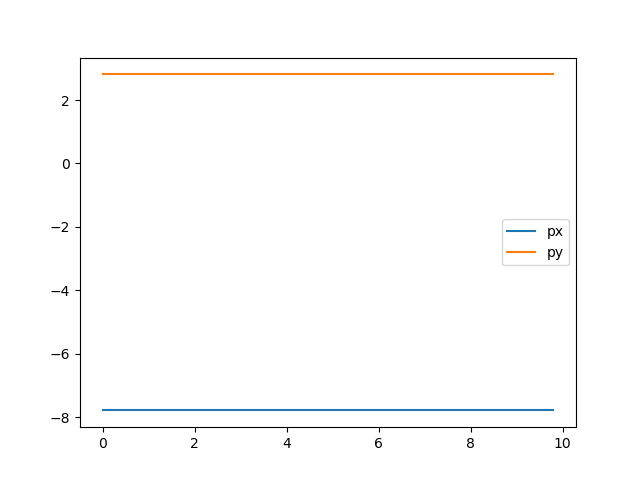

In [53]:
fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
ax3.plot(t1,MomentumT[:,0],label='px')
ax3.plot(t1,MomentumT[:,1],label='py')
ax3.legend()

a) b) Se conservan tanto el momento en x como en y. Esto es porque los choques se modelan como si fueran elásticos. Una parte de la energía cinética se convierte en potencial, pero esta se vuelve a convertir a cinética completamente.

c) La fuerza es conservativa ya que el trabajo hecho por esta depende de la dirección en la que se haga. Si la bola se comprime una distancia x, se hace un trabajo en esta. Si la bola se deja descomprimir la misma distancia x, la bola hace un trabajo de igual magnitud. La suma de estos trabajos es igual a 0, y la fuerza es conservativa. La energía potencial sería la integral de esta fuerza, lo que daría (1/4) * k * x^4

<IPython.core.display.Javascript object>


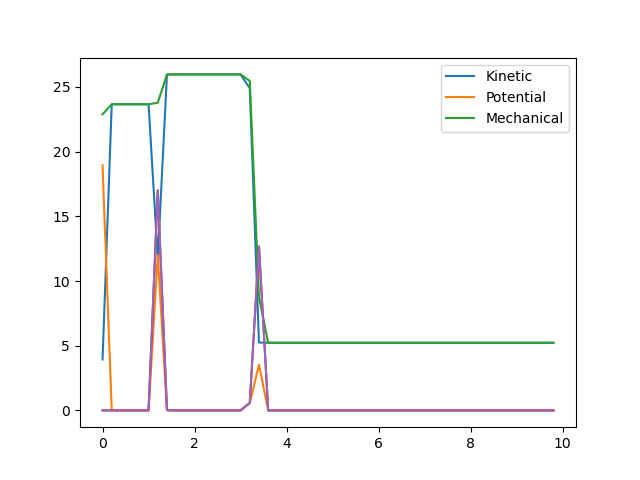

In [55]:
EKT = Particles[0].GetKineticEnergy(scale)
EPT = Particles[0].GetPotential(scale)

for i in range(1, len(Particles)):
    np.add(EKT, Particles[i].GetKineticEnergy(scale))
    np.add(EPT, Particles[i].GetPotential(scale))

EMT = EKT + EPT/2

fig4 = plt.figure()
ax4 = fig4.add_subplot(111)
ax4.plot(t1, EKT, label='Kinetic')
ax4.plot(t1, EPT/2, label='Potential')
ax4.plot(t1, EMT, label='Mechanical')
#ax4.set_xlim(0,0.75)
plt.legend()




d) La energía cinética aumenta cuando las partículas se están chocando, entonces no se conserva
e) Que el potencial sea positivo significa que es un potencial de repulsión y que las partículas no se atraen.
f) La energía mecánica no se conserva, esta fluctua y no es constante. Es como si se creara energía cuando las partículas se chocan, como si se estuvieran calentando sin perder velocidad. Esto sucede ya que el método de Euler no es consistente y se desvía de la integración verdadera conforme pasa el tiempo.
g) El teorema trabajo energía no se cumple en la simulación. Si bien al comprimirse las bolas la energía cinética se convierte en potencial, en donde la fuerza de compresión hace trabajo que más tarde se vuelve a convertir en energía cinética, la energía total del sistema aumenta sin ninguna explicación, lo que no es consistente con la física.

<IPython.core.display.Javascript object>


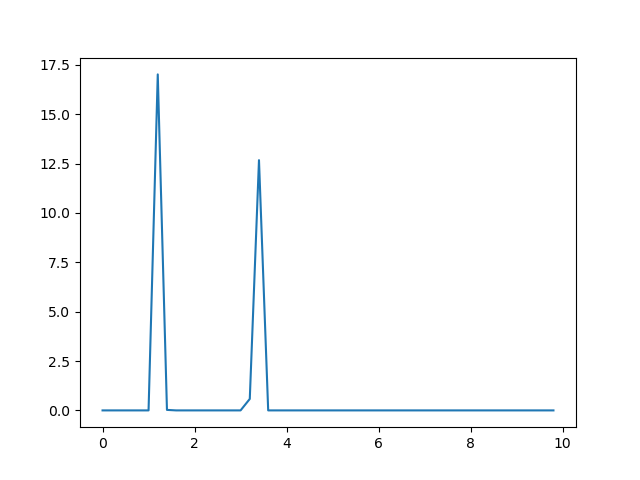

In [62]:
L = Particles[0].L[::scale]

for i in range(1, len(Particles)):
    np.add(L, Particles[i].L[::scale])
    
fig5 = plt.figure()
ax5 = fig5.add_subplot(111)
ax5.plot(t1, L, label='Angular')

h) Parece que el momento angular aumenta cuando las partículas colisionan. Sin embargo, el total de momento no parece cancelarse, entonces el momento angular no se conserva.

i) Dado el aumento de momento angular durante las colisiones, y la forma en que este cambia justo antes y después de las mismas, existiría un torque que hace que el momento cambie, por lo que es probable que las moléculas se movieran también por la dimensión z, llenando el voumen.
